In [31]:
!pip install tensorflow
!pip install keras
!pip install imblearn
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn
!pip install tensorflow-addons

ERROR: Could not find a version that satisfies the requirement typing-extensions<3.11,>=3.7 (from tensorflow) (from versions: none)
ERROR: No matching distribution found for typing-extensions<3.11,>=3.7
ERROR: Could not find a version that satisfies the requirement imblearn (from versions: none)
ERROR: No matching distribution found for imblearn


### <font color=orange> Importing Libraries </font>

In [2]:
import numpy as np
import random

#   Plotting
import seaborn as sns
import matplotlib.pyplot as plt


#   DataGenerator to read images and rescale images
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
import tensorflow_addons as tfa

#   count each class samples
from collections import Counter

#   callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau

#   evaluate precison recall and f1-score of each class of model
from sklearn.metrics import classification_report
#   Show performance of a classification model
from sklearn.metrics import confusion_matrix

#   Different layers
from keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import Softmax

# split dataset to train, validation and test set
from sklearn.model_selection import train_test_split

#   callbacks
from keras import callbacks

#   SMOTETomek from imblance library
from imblearn.combine import SMOTETomek

#   Optimizer
from tensorflow.keras.optimizers import SGD

from sklearn.metrics import roc_curve, auc
from itertools import cycle

### <font color=orange> Define directory of dataset & Classes names </font>

In [3]:
WORKING_DIRECTORY =  "/kaggle/input/alz-dataset/dataset"

##  Name of classes 
CLASSES = ['Mild-Demented',
           'Moderate-Demented',
           'Non-Demented',
           'VeryMild-Demented']

### <font color=orange> Load and Rescale Images, and seperate from data generator & Label One Hot encoding </font>

In [4]:
X, y = [], []
height, width = 128, 128

## Images rescaling
datagen = ImageDataGenerator(rescale=1.0/255.0)

#   Load images by resizing and shuffling randomly
train_dataset = datagen.flow_from_directory(WORKING_DIRECTORY, target_size=(height, width),batch_size=6400, shuffle=True)

### Seperate Dataset from  Data Genrator
X, y = train_dataset.next()

Found 6400 images belonging to 4 classes.


In [5]:
samples_before = len(X)
print("Images shape :\t", X.shape)
print("Labels shape :\t", y.shape)

Images shape :	 (6400, 128, 128, 3)
Labels shape :	 (6400, 4)


In [6]:
# Number of samples in classes 
print("Number of samples in each class:\t", sorted(Counter(np.argmax(y, axis=1)).items()))

# class labels as per indices
print("Classes Names according to index:\t", train_dataset.class_indices)

Number of samples in each class:	 [(0, 896), (1, 64), (2, 3200), (3, 2240)]
Classes Names according to index:	 {'MildDemented': 0, 'ModerateDemented': 1, 'NonDemented': 2, 'VeryMildDemented': 3}


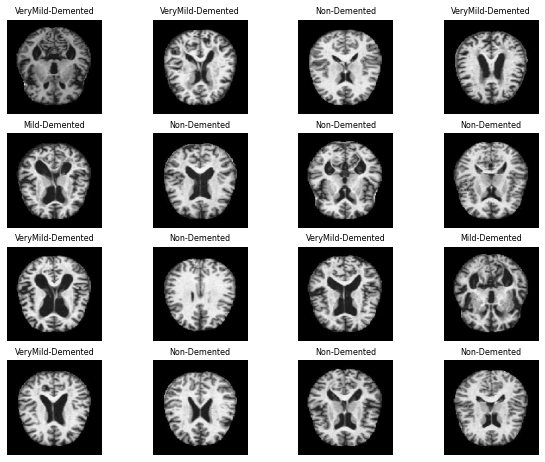

In [7]:
fig = plt.figure(figsize=(10,8))

rows = 4
columns = 4

for i in range(rows * columns):
    fig.add_subplot(rows, columns, i+1)
    num = random.randint(0, len(X)-1 )
    plt.imshow(X[num])
    plt.axis('off')
    plt.title(CLASSES[(np.argmax(y[num]))], fontsize=8)
plt.axis('off')
plt.show()

In [8]:
#   reshaping the images to 1D
X = X.reshape(-1, width * height * 3)

#   Oversampling method to remove imbalance class problem
X, y = SMOTETomek().fit_resample(X, y)

# #   reshape images to images size of 208, 176, 3
# X = X.reshape(-1, width, height, 3)

samples_after = len(X)
print("Number of samples after SMOTETomek :\t", sorted(Counter(np.argmax(y, axis=1)).items()))

Number of samples after SMOTETomek :	 [(0, 3200), (1, 3200), (2, 3200), (3, 3200)]


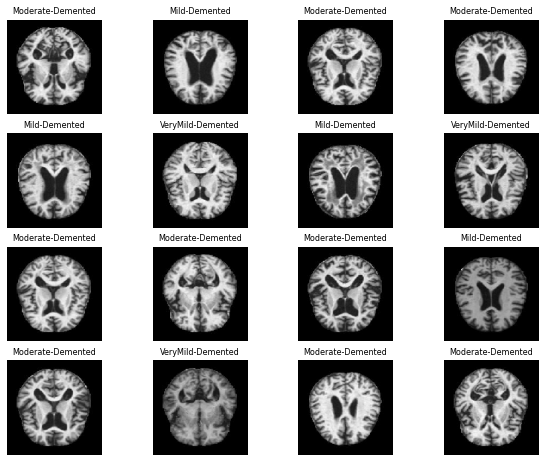

In [9]:
fig = plt.figure(figsize=(10,8))

rows = 4
columns = 4

for i in range(rows * columns):
    fig.add_subplot(rows, columns, i+1)
    num = random.randint(samples_before, samples_after - 1 )
    plt.imshow(X[num])
    plt.axis('off')
    plt.title(CLASSES[(np.argmax(y[num]))], fontsize=8)
plt.axis('off')
plt.show()

### <font color=orange> Splitting dataset for Training, Validation & Testing </font>

In [10]:
# 20% split to validation and 80% split to train set
X_train, x_val, y_train, y_val = train_test_split(X,y, test_size = 0.2)

# 20% split to test from 80% of train and 60% remains in train set
X_train, x_test, y_train, y_test = train_test_split(X_train,y_train, test_size = 0.2)

print("Number of samples after splitting into Training, validation & test set\n")

print("Train     \t",sorted(Counter(np.argmax(y_train, axis=1)).items()))
print("Validation\t",sorted(Counter(np.argmax(y_val, axis=1)).items()))
print("Test      \t",sorted(Counter(np.argmax(y_test, axis=1)).items()))

Number of samples after splitting into Training, validation & test set

Train     	 [(0, 2043), (1, 2055), (2, 2062), (3, 2032)]
Validation	 [(0, 643), (1, 647), (2, 640), (3, 630)]
Test      	 [(0, 514), (1, 498), (2, 498), (3, 538)]


In [11]:
del X, y

### <font color=orange> Model Architecture </font>


In [12]:
from keras.initializers import GlorotUniformV2
init = GlorotUniformV2

model = Sequential()

model.add(Input(shape=(width, height, 3)))

model.add(Convolution2D(16, 5, kernel_initializer=init))
model.add(ReLU())
model.add(AveragePooling2D(pool_size=(2,2)))

model.add(Convolution2D(32, 5, kernel_initializer=init))
model.add(ReLU())
model.add(AveragePooling2D(pool_size=(2,2)))

model.add(Convolution2D(64, 5, kernel_initializer=init))
model.add(ReLU())
model.add(AveragePooling2D(pool_size=(2,2)))

model.add(Convolution2D(128, 5, kernel_initializer=init))
model.add(ReLU())
model.add(AveragePooling2D(pool_size=(2,2)))


model.add(Dropout(0.01))

model.add(Flatten())

model.add(Dense(256, kernel_initializer=init))
model.add(ReLU())
model.add(Dropout(0.03))

model.add(Dense(4, kernel_initializer=init))
model.add(Softmax())

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 124, 124, 16)      1216      
_________________________________________________________________
re_lu (ReLU)                 (None, 124, 124, 16)      0         
_________________________________________________________________
average_pooling2d (AveragePo (None, 62, 62, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 58, 58, 32)        12832     
_________________________________________________________________
re_lu_1 (ReLU)               (None, 58, 58, 32)        0         
_________________________________________________________________
average_pooling2d_1 (Average (None, 29, 29, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 64)        5

### <font color=orange> Compiling the Model </font>

In [13]:
model.compile(
    optimizer=SGD(learning_rate=0.01), 
    loss = tf.keras.losses.CategoricalCrossentropy(name='loss'), 
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name='acc'), 
        tf.keras.metrics.AUC(name='auc'),
        tfa.metrics.F1Score(num_classes=4),
        tf.metrics.Precision(name="precision"),
        tf.metrics.Recall(name="recall") ])


### <font color=orange> Defining CALLBACKS to reduce Learning Rate </font>

In [14]:
rop_callback = ReduceLROnPlateau(monitor="val_loss", patience=2)

CALLBACKS = [rop_callback]

### <font color=orange> Training of the Model </font>

In [18]:
# declare to run on small gpu create batch sizes of images
valAug = ImageDataGenerator()

batch_size = 40

history = model.fit(valAug.flow(X_train, y_train, batch_size=batch_size, shuffle = True),
steps_per_epoch=len(X_train) // batch_size,
validation_data=valAug.flow(x_val, y_val, batch_size=batch_size, shuffle = True),
validation_steps=len(x_test) // batch_size,
epochs= 15,
batch_size=batch_size,
callbacks = CALLBACKS
)

Epoch 1/15
204/204 [==============================] - 53s 258ms/step - loss: 0.6234 - acc: 0.7115 - auc: 0.9266 - f1_score: 0.7078 - precision: 0.7897 - recall: 0.6053 - val_loss: 0.5882 - val_acc: 0.7441 - val_auc: 0.9372 - val_f1_score: 0.7232 - val_precision: 0.8225 - val_recall: 0.6270
Epoch 2/15
204/204 [==============================] - 53s 259ms/step - loss: 0.6001 - acc: 0.7309 - auc: 0.9326 - f1_score: 0.7265 - precision: 0.7988 - recall: 0.6359 - val_loss: 0.5497 - val_acc: 0.7681 - val_auc: 0.9453 - val_f1_score: 0.7644 - val_precision: 0.8137 - val_recall: 0.6936
Epoch 3/15
204/204 [==============================] - 57s 281ms/step - loss: 0.5831 - acc: 0.7303 - auc: 0.9360 - f1_score: 0.7260 - precision: 0.7946 - recall: 0.6515 - val_loss: 0.5793 - val_acc: 0.7402 - val_auc: 0.9383 - val_f1_score: 0.7327 - val_precision: 0.8093 - val_recall: 0.6510
Epoch 4/15
204/204 [==============================] - 52s 256ms/step - loss: 0.5483 - acc: 0.7570 - auc: 0.9444 - f1_score: 0.7

### <font color=orange> Evaluation of Model with the Test data </font>

In [19]:
test_scores = model.evaluate(x_test, y_test, batch_size = 32)
print("\n\nTesting Loss : \t\t {0:0.6f}".format(test_scores[0] ))
print("Testing Accuracy : \t {0:0.6f} %".format(test_scores[1] * 100))
print("Testing AC : \t\t {0:0.6f} %".format(test_scores[2] * 100))
print("Testing F1-Score : \t {0:0.6f} %".format(((test_scores[3][0] + test_scores[3][1] + test_scores[3][2] + test_scores[3][3])/4) * 100))
print("Testing Precision : \t {0:0.6f} %".format(test_scores[4] * 100))
print("Testing Recall : \t {0:0.6f} %".format(test_scores[5] * 100))

64/64 [==============================] - 5s 73ms/step - loss: 0.1780 - acc: 0.9346 - auc: 0.9947 - f1_score: 0.9349 - precision: 0.9420 - recall: 0.9277


Testing Loss : 		 0.177957
Testing Accuracy : 	 93.457031 %
Testing AC : 		 99.465644 %
Testing F1-Score : 	 93.488884 %
Testing Precision : 	 94.199306 %
Testing Recall : 	 92.773438 %


### <font color=orange> Model Training graphs </font>
- Accuracy
- Loss
- AUC
- Precision
- Recall
- F1-Score

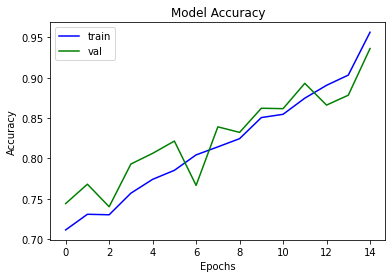

In [20]:
plt.plot(history.history['acc'], 'b')
plt.plot(history.history['val_acc'], 'g')
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["train", "val"])
plt.show()

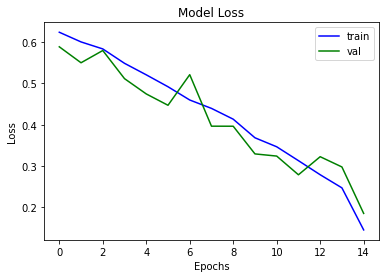

In [21]:
plt.plot(history.history['loss'], 'b')
plt.plot(history.history['val_loss'], 'g')
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["train", "val"])
plt.show()

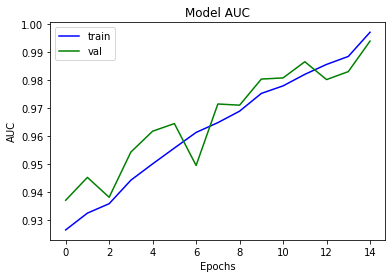

In [22]:
plt.plot(history.history['auc'], 'b')
plt.plot(history.history['val_auc'], 'g')
plt.title("Model AUC")
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.legend(["train", "val"])
plt.show()

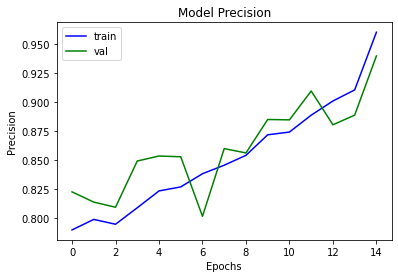

In [23]:
plt.plot(history.history['precision'], 'b')
plt.plot(history.history['val_precision'], 'g')
plt.title("Model Precision")
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.legend(["train", "val"])
plt.show()

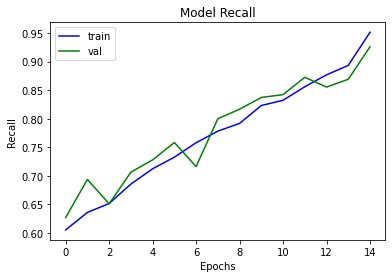

In [24]:
plt.plot(history.history['recall'], 'b')
plt.plot(history.history['val_recall'], 'g')
plt.title("Model Recall")
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.legend(["train", "val"])
plt.show()

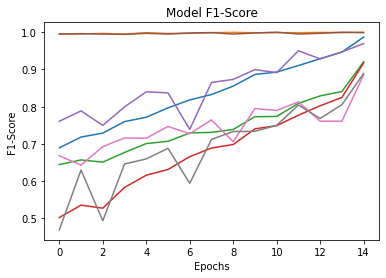

In [25]:
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title("Model F1-Score")
plt.xlabel("Epochs")
plt.ylabel("F1-Score")
plt.show()

### <font color=orange> Test set Evaluation </font>
- Classification Report
- Confusion Matrix
- ROC Curve

In [26]:
pred_labels = model.predict(x_test, batch_size=32)

def roundoff(arr):
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(y_test, pred_labels, target_names=CLASSES))


                   precision    recall  f1-score   support

    Mild-Demented       0.96      0.99      0.97       514
Moderate-Demented       1.00      1.00      1.00       498
     Non-Demented       0.88      0.88      0.88       498
VeryMild-Demented       0.90      0.88      0.89       538

        micro avg       0.93      0.93      0.93      2048
        macro avg       0.93      0.94      0.93      2048
     weighted avg       0.93      0.93      0.93      2048
      samples avg       0.93      0.93      0.93      2048



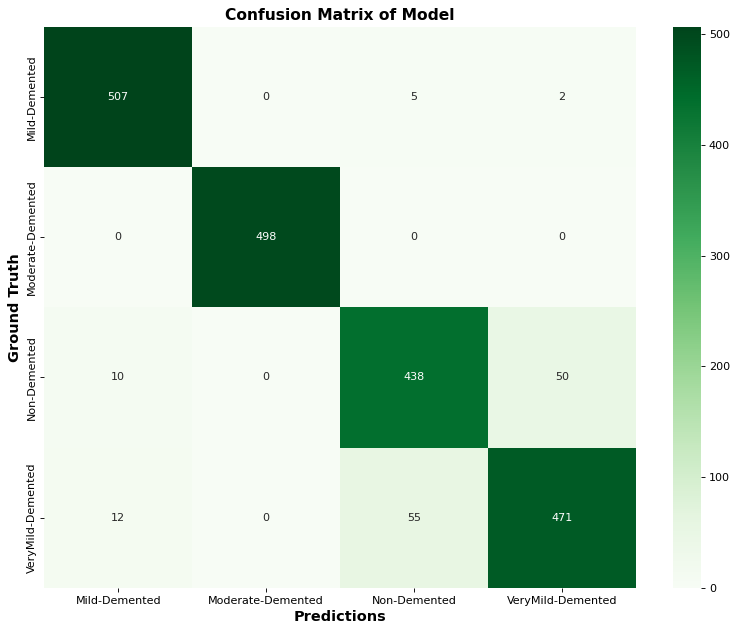

In [27]:
pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(y_test, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels= CLASSES, yticklabels=CLASSES)

plt.title('Confusion Matrix of Model', fontweight='bold', fontsize=14.0)
plt.xlabel('Predictions', fontweight='bold', fontsize=13)
plt.ylabel('Ground Truth', fontweight='bold', fontsize=13)
plt.tight_layout()
plt.show(ax)

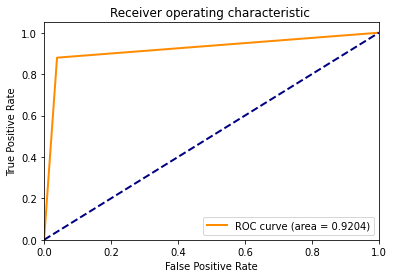

In [28]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], pred_labels[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), pred_labels.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(
    fpr[2],
    tpr[2],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.4f)" % roc_auc[2])

plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic ")
plt.legend(loc="lower right")
plt.show()

### <font color=orange> Saving Model for Future Use </font>

In [30]:
#    To save the model in the current directory
model.save(".\\model.h5")